# FluiditySaramitoNonlocal: Full EVP + Shear Banding Analysis

This notebook demonstrates the complete Saramito-Fluidity framework with:
- Tensorial stress field τ(y,t) with spatial resolution
- Fluidity diffusion for shear band formation
- Normal stress differences N₁(y) localization
- Comparison with local (0D) approximation

**Model**: FluiditySaramitoNonlocal - Elastoviscoplastic thixotropy with spatial effects

**Reference**: Saramito (2007, 2009) + Benito et al. (2008) spatial extension

## Setup

In [1]:
# Google Colab compatibility
try:
    import google.colab
    IN_COLAB = True
    !pip install -q rheojax jaxlib jax nlsq numpyro arviz
except ImportError:
    IN_COLAB = False

# Standard imports
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# RheoJAX imports with safe JAX configuration
from rheojax.core.jax_config import safe_import_jax
from rheojax.utils.metrics import compute_fit_quality
jax, jnp = safe_import_jax()

from rheojax.models.fluidity import FluiditySaramitoNonlocal, FluiditySaramitoLocal
from rheojax.core.data import RheoData
# Note: plot_model_predictions removed (not in visualization API)

# Bayesian workflow
import arviz as az

# Configure plotting
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

print(f"JAX devices: {jax.devices()}")
print(f"Float64 enabled: {jax.config.jax_enable_x64}")

JAX devices: [CpuDevice(id=0)]
Float64 enabled: True


In [2]:
def compute_fit_quality(y_true, y_pred):
    """Compute R² and RMSE."""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    residuals = y_true - y_pred
    if y_true.ndim > 1:
        residuals = residuals.ravel()
        y_true = y_true.ravel()
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else 0.0
    rmse = np.sqrt(np.mean(residuals**2))
    return {'R2': r2, 'RMSE': rmse}

## Theory: Spatial Tensorial Stress Field

### Governing Equations

The nonlocal model extends the local Saramito-Fluidity framework to include spatial variation across the gap (y-direction):

**1. Tensorial Stress Evolution**
$$
\mathbf{\tau}(y,t) + \lambda(y,t) \overset{\nabla}{\mathbf{\tau}} = 2\eta_\infty \mathbf{D}
$$

where:
- $\mathbf{\tau}(y,t) = [\tau_{xx}(y), \tau_{yy}(y), \tau_{xy}(y)]$ is the spatial stress field
- $\lambda(y,t) = 1/f(y,t)$ is the spatially-varying relaxation time
- $\overset{\nabla}{\mathbf{\tau}}$ is the upper-convected derivative
- $\mathbf{D}$ is the rate-of-strain tensor

**2. Von Mises Yielding**
$$
\alpha(y,t) = \max\left(0, 1 - \frac{\tau_y(y,t)}{|\mathbf{\tau}(y,t)|}\right)
$$

**3. Fluidity PDE with Diffusion**
$$
\frac{\partial f}{\partial t} = \frac{f_{\text{loc}}(y,t) - f(y,t)}{t_a} + \xi^2 \frac{\partial^2 f}{\partial y^2}
$$

where:
- $f_{\text{loc}}(y,t) = 1 + b|\dot{\gamma}(y,t)|^n$ is the local equilibrium fluidity
- $\xi$ is the fluidity diffusion length (typically $\xi \sim 10\text{-}100 \mu\text{m}$)
- Diffusion term $\xi^2 \partial^2 f/\partial y^2$ enables shear band formation

**4. Normal Stress Localization**
$$
N_1(y) = \tau_{xx}(y) - \tau_{yy}(y)
$$

The spatial resolution allows detection of:
- Shear band width and position
- Fluidity gradients across bands
- Normal stress concentration zones

### Coupling Modes

**Minimal coupling**: $\lambda(y,t) = 1/f(y,t)$ only

**Full coupling**: $\lambda(y,t) = 1/f(y,t)$ and $\tau_y(y,t) = \tau_{y0} f(y,t)^{-m}$ (aging yield stress)

## Load Emulsion Flow Curve Data

We'll generate synthetic emulsion data with characteristic yield stress plateau and shear-thinning behavior typical of soft glassy materials.

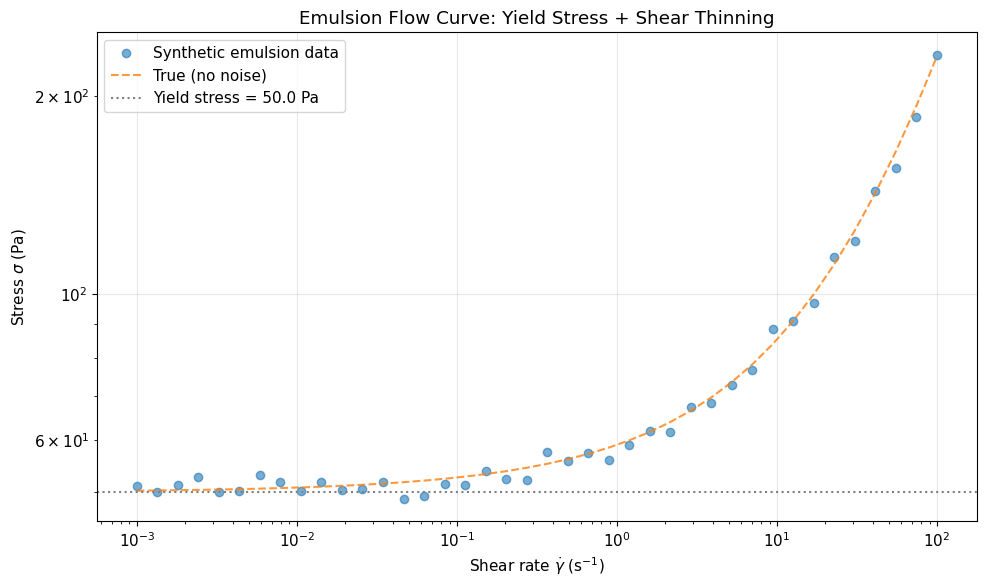

Data points: 40
Shear rate range: 1.0e-03 to 1.0e+02 s⁻¹
Stress range: 48.8 to 231.4 Pa


In [3]:
# Generate synthetic emulsion flow curve
# Characteristic: yield stress ~50 Pa, high shear viscosity ~1 Pa·s, power-law index ~0.5

np.random.seed(42)

# Shear rate range covering yield and flow regimes
gamma_dot = np.logspace(-3, 2, 40)  # 0.001 to 100 s⁻¹

# Herschel-Bulkley with parameters typical of yield-stress fluids
tau_y_true = 50.0      # Yield stress (Pa)
K_true = 8.0           # Consistency (Pa·s^n)
n_true = 0.5           # Power-law index
eta_inf_true = 1.0     # High-shear viscosity (Pa·s)

# Stress with viscosity: σ = τ_y + K*γ̇^n + η_∞*γ̇
stress_clean = tau_y_true + K_true * gamma_dot**n_true + eta_inf_true * gamma_dot

# Add 3% noise
noise = np.random.normal(0, 0.03 * stress_clean)
stress = stress_clean + noise

# Create RheoData (use x_units/y_units instead of x_label/y_label)
rheo_data = RheoData(
    x=gamma_dot,
    y=stress,
    initial_test_mode='flow_curve',
    x_units='1/s',
    y_units='Pa'
)

# Plot data
fig, ax = plt.subplots()
ax.loglog(gamma_dot, stress, 'o', label='Synthetic emulsion data', alpha=0.6)
ax.loglog(gamma_dot, stress_clean, '--', label='True (no noise)', alpha=0.8)
ax.axhline(tau_y_true, color='gray', linestyle=':', label=f'Yield stress = {tau_y_true} Pa')
ax.set_xlabel(r'Shear rate $\dot{\gamma}$ (s$^{-1}$)')
ax.set_ylabel(r'Stress $\sigma$ (Pa)')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_title('Emulsion Flow Curve: Yield Stress + Shear Thinning')
plt.tight_layout()
plt.show()

print(f"Data points: {len(gamma_dot)}")
print(f"Shear rate range: {gamma_dot.min():.1e} to {gamma_dot.max():.1e} s⁻¹")
print(f"Stress range: {stress.min():.1f} to {stress.max():.1f} Pa")

## Initialize Nonlocal Model

Key parameters:
- `coupling="minimal"`: Only $\lambda(y,t) = 1/f(y,t)$ coupling
- `n_points=51`: Spatial resolution (odd number for centered grid)
- `gap_width`: Physical gap width (default 1 mm for typical rheometer)

In [4]:
# Initialize nonlocal model
model_nonlocal = FluiditySaramitoNonlocal(
    coupling="minimal",
    N_y=51,               # Spatial resolution
    H=1e-3                # 1 mm gap (H = gap width)
)

print("FluiditySaramitoNonlocal initialized")
print(f"Coupling mode: {model_nonlocal.coupling}")
print(f"Spatial points: {model_nonlocal.N_y}")
print(f"Gap width: {model_nonlocal.H * 1e3:.1f} mm")
print(f"\nParameters:")
for name, param in model_nonlocal.parameters.items():
    print(f"  {name}: bounds={param.bounds}")

FluiditySaramitoNonlocal initialized
Coupling mode: minimal
Spatial points: 51
Gap width: 1.0 mm

Parameters:
  G: bounds=(10.0, 100000000.0)
  eta_s: bounds=(0.0, 1000.0)
  tau_y0: bounds=(0.1, 100000.0)
  K_HB: bounds=(0.01, 100000.0)
  n_HB: bounds=(0.1, 1.5)
  f_age: bounds=(1e-12, 0.01)
  f_flow: bounds=(1e-06, 1.0)
  t_a: bounds=(0.01, 100000.0)
  b: bounds=(0.0, 1000.0)
  n_rej: bounds=(0.1, 3.0)
  xi: bounds=(1e-07, 0.01)


## NLSQ Fitting

Fast point estimation using NLSQ optimizer (GPU-accelerated, 5-270x faster than scipy).

NLSQ Optimization Results
R²: 0.994673
RMSE: 2.9577 Pa

Fitted Parameters:
  G = 1.000000e+01
  eta_s = 2.389234e+02
  tau_y0 = 5.060989e+01
  K_HB = 7.130933e+00
  n_HB = 6.854198e-01
  f_age = 4.322299e-05
  f_flow = 4.322299e-01
  t_a = 1.000000e+01
  b = 1.000000e+00
  n_rej = 1.000000e+00
  xi = 1.000000e-05


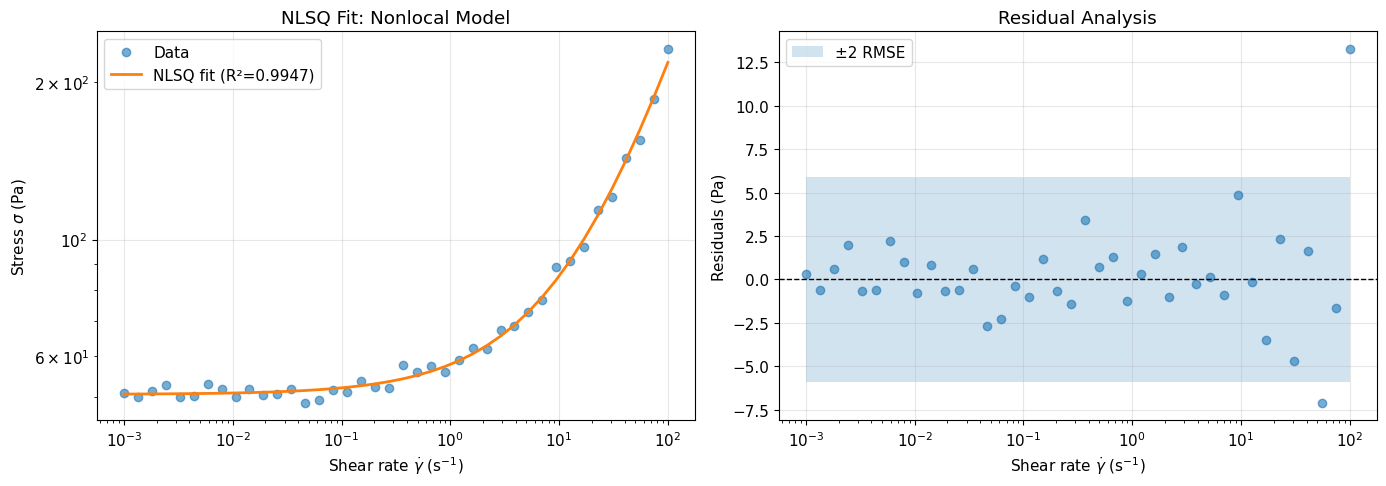

In [5]:
# Fit with NLSQ
model_nonlocal.fit(gamma_dot, stress, test_mode='flow_curve', method='scipy')

# Compute fit quality
stress_fit = np.array(model_nonlocal.predict(gamma_dot, test_mode='flow_curve')).flatten()
metrics_nlsq = compute_fit_quality(stress, stress_fit)
r_squared = metrics_nlsq['R2']
rmse = metrics_nlsq['RMSE']

print("NLSQ Optimization Results")
print("=" * 50)
print(f"R²: {r_squared:.6f}")
print(f"RMSE: {rmse:.4f} Pa")
print(f"\nFitted Parameters:")
for name in model_nonlocal.parameters.keys():
    value = model_nonlocal.parameters.get_value(name)
    print(f"  {name} = {value:.6e}")

# Predictions
stress_fit_curve = np.array(model_nonlocal.predict(gamma_dot, test_mode='flow_curve')).flatten()

# Plot fit
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Fit quality
ax1.loglog(gamma_dot, stress, 'o', label='Data', alpha=0.6)
ax1.loglog(gamma_dot, stress_fit_curve, '-', label=f'NLSQ fit (R²={r_squared:.4f})', linewidth=2)
ax1.set_xlabel(r'Shear rate $\dot{\gamma}$ (s$^{-1}$)')
ax1.set_ylabel(r'Stress $\sigma$ (Pa)')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_title('NLSQ Fit: Nonlocal Model')

# Residuals
residuals = stress - stress_fit_curve
ax2.semilogx(gamma_dot, residuals, 'o', alpha=0.6)
ax2.axhline(0, color='k', linestyle='--', linewidth=1)
ax2.fill_between(gamma_dot, -2*rmse, 2*rmse, alpha=0.2, label='±2 RMSE')
ax2.set_xlabel(r'Shear rate $\dot{\gamma}$ (s$^{-1}$)')
ax2.set_ylabel('Residuals (Pa)')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_title('Residual Analysis')

plt.tight_layout()
plt.show()
plt.close('all')

## Bayesian Inference with NUTS

Full posterior distributions using NumPyro's No-U-Turn Sampler (NUTS) with NLSQ warm-start.

In [6]:
# Bayesian inference with 4 chains (production-ready diagnostics)
result_bayes = model_nonlocal.fit_bayesian(
    rheo_data.x,
    rheo_data.y,
    test_mode='flow_curve',
    num_warmup=1000,
    num_samples=2000,
    num_chains=4,
    seed=42
)

print("Bayesian Inference Results")
print("=" * 50)

# Posterior means and credible intervals
intervals = model_nonlocal.get_credible_intervals(
    result_bayes.posterior_samples,
    credibility=0.95
)

print("\nPosterior Summary (95% HDI):")
for name in model_nonlocal.parameters.keys():
    samples = result_bayes.posterior_samples[name]
    mean = samples.mean()
    lower, upper = intervals[name]
    print(f"  {name}:")
    print(f"    Mean = {mean:.6e}")
    print(f"    95% HDI = [{lower:.6e}, {upper:.6e}]")

  0%|          | 0/3000 [00:00<?, ?it/s]

warmup:   0%|          | 1/3000 [00:02<1:56:12,  2.32s/it]

warmup:   0%|          | 2/3000 [00:04<1:56:36,  2.33s/it]

warmup:   0%|          | 6/3000 [00:04<27:46,  1.80it/s]  

warmup:   0%|          | 9/3000 [00:04<16:15,  3.06it/s]

warmup:   0%|          | 11/3000 [00:05<12:11,  4.09it/s]

warmup:   0%|          | 14/3000 [00:05<08:38,  5.76it/s]

warmup:   1%|          | 16/3000 [00:05<06:58,  7.14it/s]

warmup:   1%|          | 19/3000 [00:05<05:07,  9.69it/s]

warmup:   1%|          | 22/3000 [00:05<04:10, 11.87it/s]

warmup:   1%|          | 25/3000 [00:05<03:48, 13.01it/s]

warmup:   1%|          | 28/3000 [00:05<03:19, 14.89it/s]

warmup:   1%|          | 30/3000 [00:06<03:19, 14.92it/s]

warmup:   1%|          | 32/3000 [00:06<03:15, 15.19it/s]

warmup:   1%|          | 34/3000 [00:06<03:05, 15.96it/s]

warmup:   1%|          | 36/3000 [00:06<03:07, 15.82it/s]

warmup:   1%|▏         | 39/3000 [00:06<02:37, 18.78it/s]

warmup:   1%|▏         | 42/3000 [00:06<02:28, 19.98it/s]

warmup:   2%|▏         | 45/3000 [00:06<02:26, 20.17it/s]

warmup:   2%|▏         | 48/3000 [00:07<02:47, 17.61it/s]

warmup:   2%|▏         | 50/3000 [00:07<02:48, 17.46it/s]

warmup:   2%|▏         | 53/3000 [00:07<02:34, 19.12it/s]

warmup:   2%|▏         | 55/3000 [00:07<02:41, 18.18it/s]

warmup:   2%|▏         | 57/3000 [00:07<02:47, 17.58it/s]

warmup:   2%|▏         | 60/3000 [00:07<02:35, 18.94it/s]

warmup:   2%|▏         | 62/3000 [00:07<02:36, 18.76it/s]

warmup:   2%|▏         | 64/3000 [00:07<02:42, 18.09it/s]

warmup:   2%|▏         | 66/3000 [00:07<02:45, 17.71it/s]

warmup:   2%|▏         | 69/3000 [00:08<02:34, 18.94it/s]

warmup:   2%|▏         | 71/3000 [00:08<02:33, 19.03it/s]

warmup:   2%|▏         | 73/3000 [00:08<02:39, 18.31it/s]

warmup:   3%|▎         | 76/3000 [00:08<02:28, 19.67it/s]

warmup:   3%|▎         | 78/3000 [00:08<02:33, 19.02it/s]

warmup:   3%|▎         | 81/3000 [00:08<02:30, 19.34it/s]

warmup:   3%|▎         | 84/3000 [00:08<02:18, 21.06it/s]

warmup:   3%|▎         | 87/3000 [00:09<02:14, 21.67it/s]

warmup:   3%|▎         | 90/3000 [00:09<02:26, 19.83it/s]

warmup:   3%|▎         | 93/3000 [00:09<02:26, 19.81it/s]

warmup:   3%|▎         | 96/3000 [00:09<02:22, 20.39it/s]

warmup:   3%|▎         | 99/3000 [00:09<02:22, 20.38it/s]

warmup:   3%|▎         | 102/3000 [00:09<02:09, 22.43it/s]

warmup:   4%|▎         | 111/3000 [00:09<01:16, 37.93it/s]

warmup:   4%|▍         | 118/3000 [00:09<01:04, 45.02it/s]

warmup:   4%|▍         | 128/3000 [00:10<00:48, 58.94it/s]

warmup:   5%|▍         | 139/3000 [00:10<00:39, 72.58it/s]

warmup:   5%|▍         | 147/3000 [00:10<00:40, 70.59it/s]

warmup:   5%|▌         | 156/3000 [00:10<00:37, 75.89it/s]

warmup:   5%|▌         | 164/3000 [00:10<00:39, 71.64it/s]

warmup:   6%|▌         | 172/3000 [00:10<00:39, 72.40it/s]

warmup:   6%|▌         | 181/3000 [00:10<00:37, 75.84it/s]

warmup:   6%|▋         | 190/3000 [00:10<00:35, 79.05it/s]

warmup:   7%|▋         | 201/3000 [00:10<00:33, 84.59it/s]

warmup:   7%|▋         | 210/3000 [00:11<00:33, 83.92it/s]

warmup:   7%|▋         | 220/3000 [00:11<00:33, 84.10it/s]

warmup:   8%|▊         | 229/3000 [00:11<00:34, 80.70it/s]

warmup:   8%|▊         | 246/3000 [00:11<00:26, 103.31it/s]

warmup:   9%|▊         | 257/3000 [00:11<00:30, 91.37it/s] 

warmup:   9%|▉         | 269/3000 [00:11<00:27, 98.20it/s]

warmup:  10%|▉         | 285/3000 [00:11<00:23, 114.47it/s]

warmup:  10%|▉         | 297/3000 [00:11<00:24, 109.75it/s]

warmup:  10%|█         | 309/3000 [00:11<00:26, 101.51it/s]

warmup:  11%|█         | 325/3000 [00:12<00:23, 115.76it/s]

warmup:  11%|█▏        | 342/3000 [00:12<00:20, 127.84it/s]

warmup:  12%|█▏        | 357/3000 [00:12<00:19, 133.43it/s]

warmup:  12%|█▏        | 371/3000 [00:12<00:19, 131.84it/s]

warmup:  13%|█▎        | 385/3000 [00:12<00:20, 126.46it/s]

warmup:  13%|█▎        | 398/3000 [00:12<00:20, 126.72it/s]

warmup:  14%|█▎        | 411/3000 [00:12<00:20, 126.16it/s]

warmup:  14%|█▍        | 424/3000 [00:12<00:20, 124.41it/s]

warmup:  15%|█▍        | 439/3000 [00:12<00:19, 129.23it/s]

warmup:  15%|█▌        | 455/3000 [00:13<00:20, 125.69it/s]

warmup:  16%|█▌        | 468/3000 [00:13<00:23, 107.20it/s]

warmup:  16%|█▌        | 480/3000 [00:13<00:23, 107.54it/s]

warmup:  16%|█▋        | 493/3000 [00:13<00:22, 112.42it/s]

warmup:  17%|█▋        | 505/3000 [00:13<00:24, 100.14it/s]

warmup:  17%|█▋        | 523/3000 [00:13<00:21, 117.91it/s]

warmup:  18%|█▊        | 536/3000 [00:13<00:21, 115.33it/s]

warmup:  18%|█▊        | 548/3000 [00:13<00:21, 115.73it/s]

warmup:  19%|█▊        | 560/3000 [00:14<00:22, 107.07it/s]

warmup:  19%|█▉        | 571/3000 [00:14<00:25, 94.73it/s] 

warmup:  19%|█▉        | 584/3000 [00:14<00:23, 102.28it/s]

warmup:  20%|█▉        | 596/3000 [00:14<00:22, 106.16it/s]

warmup:  20%|██        | 608/3000 [00:14<00:21, 109.42it/s]

warmup:  21%|██        | 620/3000 [00:14<00:22, 107.63it/s]

warmup:  21%|██        | 634/3000 [00:14<00:20, 114.70it/s]

warmup:  22%|██▏       | 647/3000 [00:14<00:19, 118.58it/s]

warmup:  22%|██▏       | 660/3000 [00:14<00:20, 116.02it/s]

warmup:  22%|██▎       | 675/3000 [00:15<00:18, 124.65it/s]

warmup:  23%|██▎       | 688/3000 [00:15<00:19, 119.91it/s]

warmup:  23%|██▎       | 701/3000 [00:15<00:20, 111.81it/s]

warmup:  24%|██▍       | 714/3000 [00:15<00:19, 115.12it/s]

warmup:  24%|██▍       | 733/3000 [00:15<00:17, 132.36it/s]

warmup:  25%|██▌       | 754/3000 [00:15<00:14, 152.26it/s]

warmup:  26%|██▌       | 770/3000 [00:15<00:16, 135.71it/s]

warmup:  26%|██▌       | 786/3000 [00:15<00:15, 141.71it/s]

warmup:  27%|██▋       | 801/3000 [00:16<00:16, 133.23it/s]

warmup:  27%|██▋       | 815/3000 [00:16<00:17, 123.70it/s]

warmup:  28%|██▊       | 828/3000 [00:16<00:20, 108.58it/s]

warmup:  28%|██▊       | 840/3000 [00:16<00:20, 105.92it/s]

warmup:  28%|██▊       | 851/3000 [00:16<00:20, 105.17it/s]

warmup:  29%|██▉       | 865/3000 [00:16<00:18, 114.05it/s]

warmup:  29%|██▉       | 877/3000 [00:16<00:19, 108.59it/s]

warmup:  30%|██▉       | 890/3000 [00:16<00:18, 113.91it/s]

warmup:  30%|███       | 902/3000 [00:16<00:18, 114.80it/s]

warmup:  30%|███       | 914/3000 [00:17<00:18, 114.17it/s]

warmup:  31%|███       | 927/3000 [00:17<00:17, 116.75it/s]

warmup:  31%|███▏      | 939/3000 [00:17<00:17, 116.95it/s]

warmup:  32%|███▏      | 956/3000 [00:17<00:15, 128.51it/s]

warmup:  32%|███▏      | 969/3000 [00:17<00:17, 113.64it/s]

warmup:  33%|███▎      | 983/3000 [00:17<00:16, 120.25it/s]

warmup:  33%|███▎      | 999/3000 [00:17<00:15, 130.22it/s]

sample:  34%|███▍      | 1013/3000 [00:17<00:15, 129.95it/s]

sample:  34%|███▍      | 1027/3000 [00:17<00:15, 129.74it/s]

sample:  35%|███▍      | 1041/3000 [00:18<00:15, 130.04it/s]

sample:  35%|███▌      | 1055/3000 [00:18<00:15, 126.24it/s]

sample:  36%|███▌      | 1068/3000 [00:18<00:15, 123.39it/s]

sample:  36%|███▌      | 1081/3000 [00:18<00:15, 124.25it/s]

sample:  36%|███▋      | 1094/3000 [00:18<00:16, 116.43it/s]

sample:  37%|███▋      | 1106/3000 [00:18<00:17, 109.47it/s]

sample:  37%|███▋      | 1121/3000 [00:18<00:15, 119.36it/s]

sample:  38%|███▊      | 1134/3000 [00:18<00:16, 112.04it/s]

sample:  38%|███▊      | 1147/3000 [00:19<00:16, 115.19it/s]

sample:  39%|███▊      | 1159/3000 [00:19<00:15, 116.02it/s]

sample:  39%|███▉      | 1171/3000 [00:19<00:17, 102.25it/s]

sample:  39%|███▉      | 1182/3000 [00:19<00:18, 98.77it/s] 

sample:  40%|███▉      | 1198/3000 [00:19<00:15, 114.00it/s]

sample:  40%|████      | 1213/3000 [00:19<00:14, 120.37it/s]

sample:  41%|████      | 1226/3000 [00:19<00:14, 119.17it/s]

sample:  41%|████▏     | 1241/3000 [00:19<00:13, 126.68it/s]

sample:  42%|████▏     | 1255/3000 [00:19<00:13, 127.69it/s]

sample:  42%|████▏     | 1269/3000 [00:20<00:13, 129.16it/s]

sample:  43%|████▎     | 1283/3000 [00:20<00:13, 129.00it/s]

sample:  43%|████▎     | 1298/3000 [00:20<00:12, 134.95it/s]

sample:  44%|████▎     | 1312/3000 [00:20<00:13, 125.86it/s]

sample:  44%|████▍     | 1327/3000 [00:20<00:12, 129.98it/s]

sample:  45%|████▍     | 1341/3000 [00:20<00:13, 122.70it/s]

sample:  45%|████▌     | 1354/3000 [00:20<00:13, 123.17it/s]

sample:  46%|████▌     | 1368/3000 [00:20<00:12, 126.43it/s]

sample:  46%|████▌     | 1386/3000 [00:20<00:11, 138.76it/s]

sample:  47%|████▋     | 1403/3000 [00:21<00:10, 146.79it/s]

sample:  47%|████▋     | 1418/3000 [00:21<00:11, 133.31it/s]

sample:  48%|████▊     | 1432/3000 [00:21<00:12, 129.87it/s]

sample:  48%|████▊     | 1446/3000 [00:21<00:11, 132.14it/s]

sample:  49%|████▉     | 1464/3000 [00:21<00:10, 145.14it/s]

sample:  49%|████▉     | 1479/3000 [00:21<00:11, 137.73it/s]

sample:  50%|████▉     | 1493/3000 [00:21<00:11, 126.09it/s]

sample:  50%|█████     | 1506/3000 [00:21<00:12, 119.28it/s]

sample:  51%|█████     | 1519/3000 [00:21<00:12, 115.64it/s]

sample:  51%|█████     | 1531/3000 [00:22<00:12, 113.15it/s]

sample:  51%|█████▏    | 1543/3000 [00:22<00:12, 112.69it/s]

sample:  52%|█████▏    | 1555/3000 [00:22<00:13, 109.14it/s]

sample:  52%|█████▏    | 1571/3000 [00:22<00:11, 121.54it/s]

sample:  53%|█████▎    | 1584/3000 [00:22<00:11, 123.65it/s]

sample:  53%|█████▎    | 1597/3000 [00:22<00:11, 122.77it/s]

sample:  54%|█████▎    | 1611/3000 [00:22<00:10, 126.93it/s]

sample:  54%|█████▍    | 1624/3000 [00:22<00:11, 118.66it/s]

sample:  55%|█████▍    | 1637/3000 [00:22<00:11, 113.98it/s]

sample:  55%|█████▍    | 1649/3000 [00:23<00:13, 99.79it/s] 

sample:  56%|█████▌    | 1666/3000 [00:23<00:11, 115.28it/s]

sample:  56%|█████▌    | 1680/3000 [00:23<00:10, 121.32it/s]

sample:  57%|█████▋    | 1698/3000 [00:23<00:09, 136.88it/s]

sample:  57%|█████▋    | 1713/3000 [00:23<00:10, 126.95it/s]

sample:  58%|█████▊    | 1727/3000 [00:23<00:10, 126.47it/s]

sample:  58%|█████▊    | 1741/3000 [00:23<00:09, 129.74it/s]

sample:  58%|█████▊    | 1755/3000 [00:23<00:09, 132.36it/s]

sample:  59%|█████▉    | 1769/3000 [00:24<00:09, 128.63it/s]

sample:  60%|█████▉    | 1786/3000 [00:24<00:08, 138.81it/s]

sample:  60%|██████    | 1801/3000 [00:24<00:08, 135.46it/s]

sample:  60%|██████    | 1815/3000 [00:24<00:09, 124.94it/s]

sample:  61%|██████    | 1830/3000 [00:24<00:09, 129.40it/s]

sample:  61%|██████▏   | 1844/3000 [00:24<00:09, 123.80it/s]

sample:  62%|██████▏   | 1860/3000 [00:24<00:08, 133.32it/s]

sample:  62%|██████▎   | 1875/3000 [00:24<00:08, 136.87it/s]

sample:  63%|██████▎   | 1889/3000 [00:24<00:09, 121.76it/s]

sample:  63%|██████▎   | 1902/3000 [00:25<00:09, 117.12it/s]

sample:  64%|██████▍   | 1914/3000 [00:25<00:09, 109.67it/s]

sample:  64%|██████▍   | 1927/3000 [00:25<00:09, 114.27it/s]

sample:  65%|██████▍   | 1944/3000 [00:25<00:08, 127.43it/s]

sample:  65%|██████▌   | 1958/3000 [00:25<00:08, 126.70it/s]

sample:  66%|██████▌   | 1971/3000 [00:25<00:08, 125.33it/s]

sample:  66%|██████▌   | 1984/3000 [00:25<00:09, 112.25it/s]

sample:  67%|██████▋   | 1996/3000 [00:25<00:09, 107.22it/s]

sample:  67%|██████▋   | 2009/3000 [00:26<00:08, 112.74it/s]

sample:  68%|██████▊   | 2034/3000 [00:26<00:06, 148.48it/s]

sample:  69%|██████▊   | 2056/3000 [00:26<00:05, 167.51it/s]

sample:  70%|██████▉   | 2088/3000 [00:26<00:04, 209.17it/s]

sample:  70%|███████   | 2110/3000 [00:26<00:04, 212.14it/s]

sample:  71%|███████   | 2132/3000 [00:26<00:04, 182.65it/s]

sample:  72%|███████▏  | 2152/3000 [00:26<00:04, 185.06it/s]

sample:  72%|███████▏  | 2172/3000 [00:26<00:04, 187.94it/s]

sample:  73%|███████▎  | 2192/3000 [00:26<00:04, 167.01it/s]

sample:  74%|███████▎  | 2210/3000 [00:27<00:05, 154.36it/s]

sample:  74%|███████▍  | 2227/3000 [00:27<00:05, 141.68it/s]

sample:  75%|███████▍  | 2242/3000 [00:27<00:05, 140.48it/s]

sample:  75%|███████▌  | 2257/3000 [00:27<00:05, 134.72it/s]

sample:  76%|███████▌  | 2271/3000 [00:27<00:06, 119.64it/s]

sample:  76%|███████▌  | 2284/3000 [00:27<00:06, 118.61it/s]

sample:  77%|███████▋  | 2297/3000 [00:27<00:05, 119.63it/s]

sample:  77%|███████▋  | 2311/3000 [00:27<00:05, 124.80it/s]

sample:  77%|███████▋  | 2324/3000 [00:28<00:05, 119.57it/s]

sample:  78%|███████▊  | 2341/3000 [00:28<00:04, 132.67it/s]

sample:  78%|███████▊  | 2355/3000 [00:28<00:04, 132.82it/s]

sample:  79%|███████▉  | 2371/3000 [00:28<00:04, 139.69it/s]

sample:  80%|███████▉  | 2391/3000 [00:28<00:03, 154.74it/s]

sample:  80%|████████  | 2407/3000 [00:28<00:04, 139.11it/s]

sample:  81%|████████  | 2422/3000 [00:28<00:04, 139.04it/s]

sample:  81%|████████  | 2437/3000 [00:28<00:04, 128.14it/s]

sample:  82%|████████▏ | 2453/3000 [00:28<00:04, 131.99it/s]

sample:  82%|████████▏ | 2467/3000 [00:29<00:04, 127.52it/s]

sample:  83%|████████▎ | 2482/3000 [00:29<00:04, 125.16it/s]

sample:  83%|████████▎ | 2495/3000 [00:29<00:04, 122.82it/s]

sample:  84%|████████▎ | 2508/3000 [00:29<00:04, 121.09it/s]

sample:  84%|████████▍ | 2528/3000 [00:29<00:03, 140.12it/s]

sample:  85%|████████▍ | 2543/3000 [00:29<00:03, 119.90it/s]

sample:  85%|████████▌ | 2556/3000 [00:29<00:03, 118.55it/s]

sample:  86%|████████▌ | 2569/3000 [00:29<00:03, 119.90it/s]

sample:  86%|████████▌ | 2583/3000 [00:30<00:03, 123.16it/s]

sample:  87%|████████▋ | 2596/3000 [00:30<00:03, 119.29it/s]

sample:  87%|████████▋ | 2610/3000 [00:30<00:03, 124.69it/s]

sample:  87%|████████▋ | 2623/3000 [00:30<00:03, 122.37it/s]

sample:  88%|████████▊ | 2638/3000 [00:30<00:02, 126.77it/s]

sample:  88%|████████▊ | 2651/3000 [00:30<00:02, 120.45it/s]

sample:  89%|████████▉ | 2666/3000 [00:30<00:02, 122.77it/s]

sample:  89%|████████▉ | 2680/3000 [00:30<00:02, 127.20it/s]

sample:  90%|█████████ | 2701/3000 [00:30<00:01, 149.62it/s]

sample:  91%|█████████ | 2717/3000 [00:31<00:01, 151.01it/s]

sample:  91%|█████████ | 2733/3000 [00:31<00:01, 143.89it/s]

sample:  92%|█████████▏| 2748/3000 [00:31<00:01, 135.37it/s]

sample:  92%|█████████▏| 2763/3000 [00:31<00:01, 138.32it/s]

sample:  93%|█████████▎| 2777/3000 [00:31<00:01, 114.01it/s]

sample:  93%|█████████▎| 2790/3000 [00:31<00:01, 114.13it/s]

sample:  93%|█████████▎| 2802/3000 [00:31<00:01, 106.02it/s]

sample:  94%|█████████▍| 2815/3000 [00:31<00:01, 111.59it/s]

sample:  94%|█████████▍| 2827/3000 [00:32<00:01, 100.38it/s]

sample:  95%|█████████▍| 2845/3000 [00:32<00:01, 114.71it/s]

sample:  95%|█████████▌| 2860/3000 [00:32<00:01, 122.01it/s]

sample:  96%|█████████▌| 2873/3000 [00:32<00:01, 112.53it/s]

sample:  96%|█████████▌| 2885/3000 [00:32<00:01, 92.02it/s] 

sample:  97%|█████████▋| 2902/3000 [00:32<00:00, 107.83it/s]

sample:  97%|█████████▋| 2919/3000 [00:32<00:00, 120.59it/s]

sample:  98%|█████████▊| 2932/3000 [00:32<00:00, 113.31it/s]

sample:  98%|█████████▊| 2944/3000 [00:33<00:00, 101.48it/s]

sample:  99%|█████████▉| 2964/3000 [00:33<00:00, 123.63it/s]

sample:  99%|█████████▉| 2978/3000 [00:33<00:00, 121.19it/s]

sample: 100%|█████████▉| 2992/3000 [00:33<00:00, 125.68it/s]

sample: 100%|██████████| 3000/3000 [00:33<00:00, 89.57it/s] 

Bayesian Inference Results

Posterior Summary (95% HDI):
  G:
    Mean = 5.007364e+07
    95% HDI = [2.733778e+06, 9.718269e+07]
  eta_s:
    Mean = 5.012282e+02
    95% HDI = [4.722263e+01, 9.965710e+02]
  tau_y0:
    Mean = 5.119453e+01
    95% HDI = [4.993717e+01, 5.248298e+01]
  K_HB:
    Mean = 6.220063e+00
    95% HDI = [5.300164e+00, 7.151925e+00]
  n_HB:
    Mean = 7.217417e-01
    95% HDI = [6.871127e-01, 7.564163e-01]
  f_age:
    Mean = 4.987215e-03
    95% HDI = [2.208577e-04, 9.708440e-03]
  f_flow:
    Mean = 5.014142e-01
    95% HDI = [5.616932e-02, 9.997378e-01]
  t_a:
    Mean = 4.965274e+04
    95% HDI = [4.136526e+03, 9.930080e+04]
  b:
    Mean = 4.982509e+02
    95% HDI = [1.637150e+01, 9.604831e+02]
  n_rej:
    Mean = 1.548800e+00
    95% HDI = [1.004132e-01, 2.853687e+00]
  xi:
    Mean = 5.003827e-03
    95% HDI = [1.289224e-04, 9.589064e-03]


## ArviZ Diagnostics

Comprehensive MCMC convergence and posterior quality checks.

In [7]:
# Convert to ArviZ InferenceData
idata = az.from_dict(
    posterior={k: v[np.newaxis, :] for k, v in result_bayes.posterior_samples.items()}
)

# Summary statistics
summary = az.summary(idata, hdi_prob=0.95)
print("\nArviZ Summary:")
print(summary)

# Check diagnostics
print("\n" + "=" * 50)
print("Diagnostic Checks:")
print("=" * 50)
for param in model_nonlocal.parameters.keys():
    r_hat = summary.loc[param, 'r_hat']
    ess_bulk = summary.loc[param, 'ess_bulk']
    ess_tail = summary.loc[param, 'ess_tail']
    
    print(f"\n{param}:")
    print(f"  R-hat = {r_hat:.4f} {'✓ PASS' if r_hat < 1.01 else '✗ FAIL (should be < 1.01)'}")
    print(f"  ESS (bulk) = {ess_bulk:.0f} {'✓ PASS' if ess_bulk > 400 else '✗ FAIL (should be > 400)'}")
    print(f"  ESS (tail) = {ess_tail:.0f} {'✓ PASS' if ess_tail > 400 else '✗ FAIL (should be > 400)'}")

Shape validation failed: input_shape: (1, 8000), minimum_shape: (chains=2, draws=4)



ArviZ Summary:
                mean            sd     hdi_2.5%     hdi_97.5%   mcse_mean  \
G       5.007364e+07  2.853212e+07  2733777.984  9.718269e+07  281165.096   
eta_s   5.012280e+02  2.898910e+02       47.223  9.965710e+02       3.282   
tau_y0  5.119500e+01  6.490000e-01       49.937  5.248300e+01       0.009   
K_HB    6.220000e+00  4.760000e-01        5.300  7.152000e+00       0.008   
n_HB    7.220000e-01  1.800000e-02        0.687  7.560000e-01       0.000   
f_age   5.000000e-03  3.000000e-03        0.000  1.000000e-02       0.000   
f_flow  5.010000e-01  2.860000e-01        0.056  1.000000e+00       0.003   
t_a     4.965274e+04  2.932766e+04     4136.526  9.930080e+04     330.687   
b       4.982510e+02  2.883300e+02       16.371  9.604830e+02       3.243   
n_rej   1.549000e+00  8.460000e-01        0.100  2.854000e+00       0.009   
xi      5.000000e-03  3.000000e-03        0.000  1.000000e-02       0.000   

           mcse_sd  ess_bulk  ess_tail  r_hat  
G       232

/var/folders/rq/lgpr8fvj349cr_wvkzv99md80000gp/T/ipykernel_46698/3178518977.py:3: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


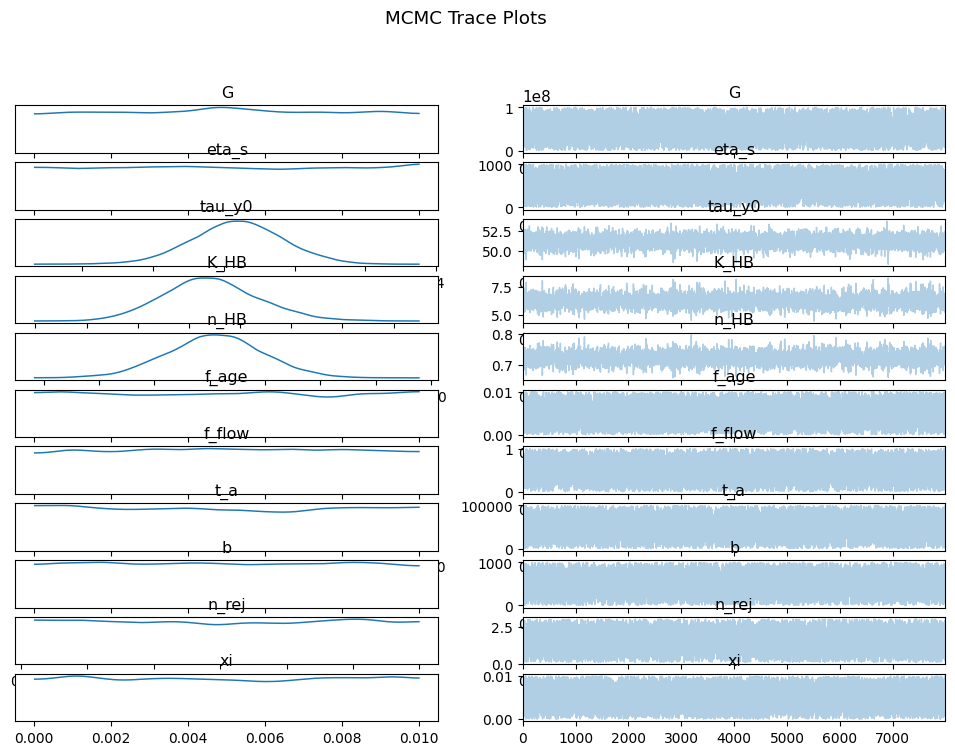

In [8]:
# Trace plots
az.plot_trace(idata, compact=True, figsize=(12, 8))
plt.tight_layout()
plt.suptitle('MCMC Trace Plots', y=1.00)
plt.show()

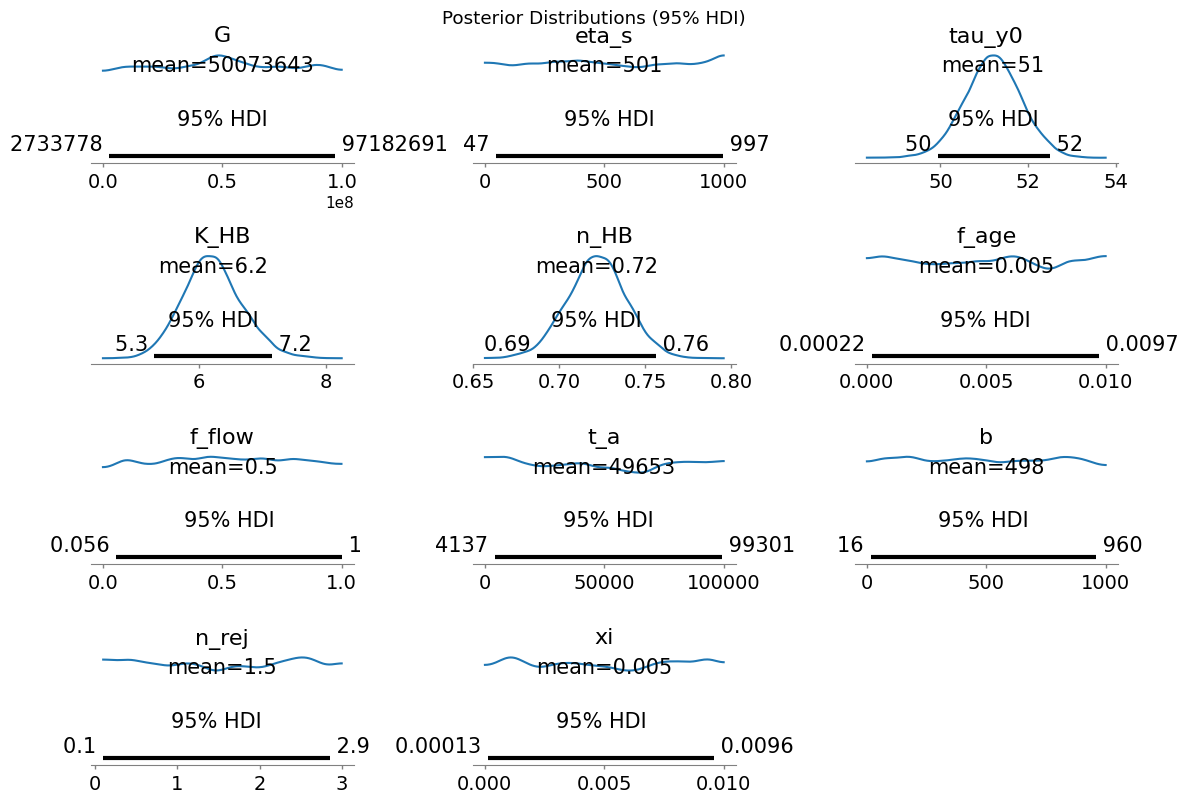

In [9]:
# Posterior distributions
az.plot_posterior(idata, hdi_prob=0.95, figsize=(12, 8))
plt.tight_layout()
plt.suptitle('Posterior Distributions (95% HDI)', y=1.00)
plt.show()

/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/arviz/plots/backends/matplotlib/pairplot.py:223: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


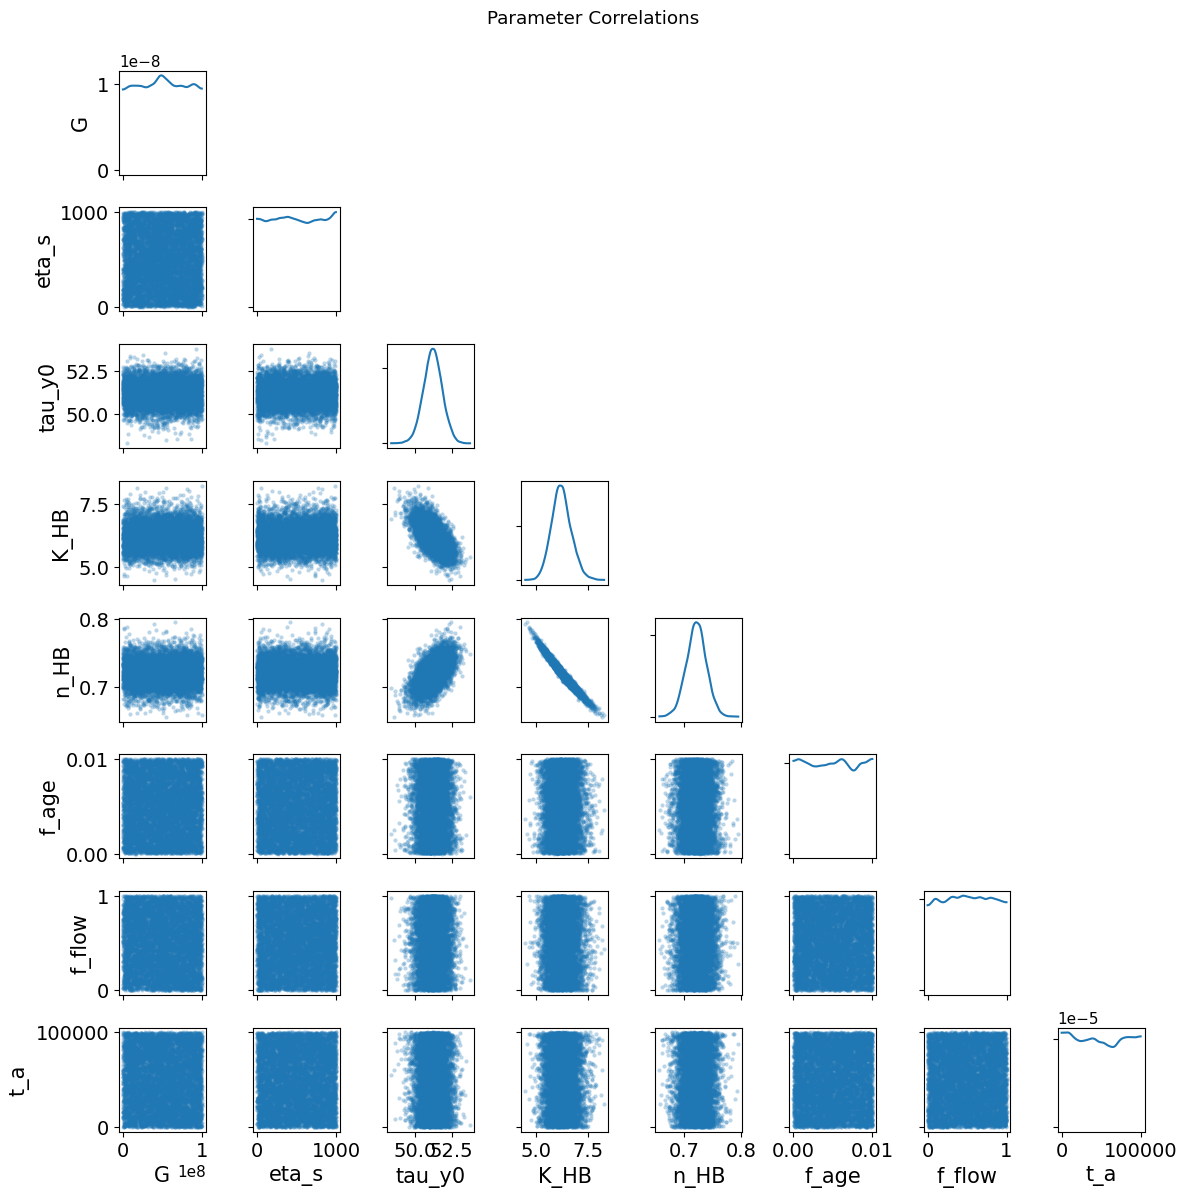

In [10]:
# Pair plot (correlations)
az.plot_pair(
    idata,
    marginals=True,
    figsize=(12, 12),
    scatter_kwargs={'alpha': 0.3}
)
plt.suptitle('Parameter Correlations', y=0.995)
plt.tight_layout()
plt.show()

## Compare with Local Model

Assess when spatial effects (shear banding) become important by comparing with the 0D local approximation.

Local Model Results
R²: 0.994673
RMSE: 2.9577 Pa

Fitted Parameters:
  G = 1.000000e+01
  eta_s = 2.389234e+02
  tau_y0 = 5.060989e+01
  K_HB = 7.130933e+00
  n_HB = 6.854198e-01
  f_age = 4.322299e-05
  f_flow = 4.322299e-01
  t_a = 1.000000e+01
  b = 1.000000e+00
  n_rej = 1.000000e+00


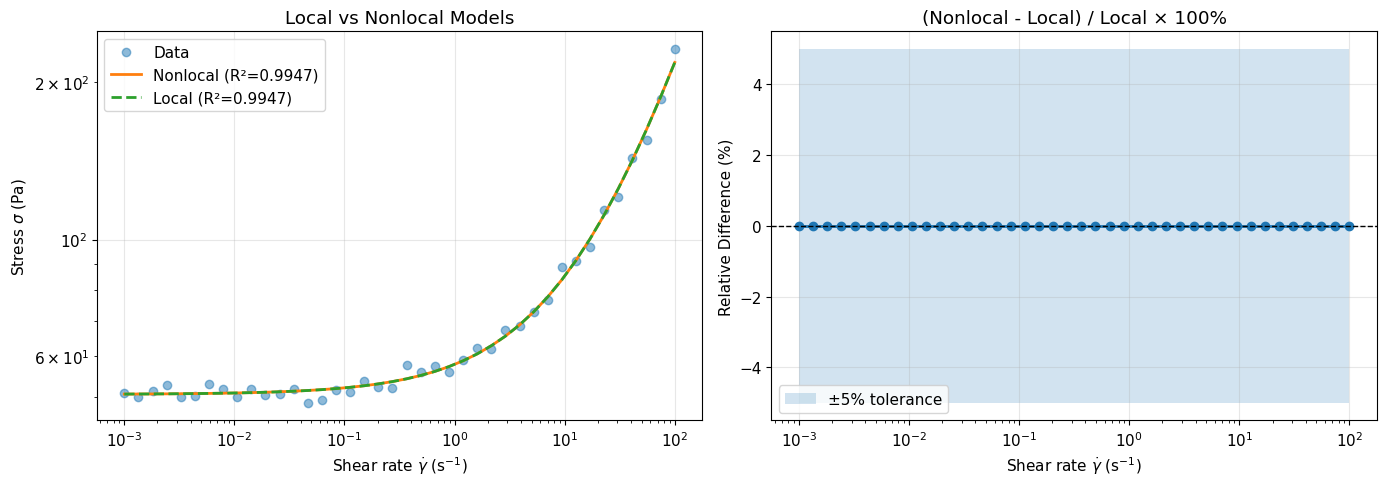


Maximum relative difference: 0.00%
Mean absolute relative difference: 0.00%


In [11]:
# Initialize and fit local model for comparison
model_local = FluiditySaramitoLocal(coupling="minimal")

model_local.fit(gamma_dot, stress, test_mode='flow_curve', method='scipy')

# Compute fit quality for local model
stress_local = np.array(model_local.predict(gamma_dot, test_mode='flow_curve')).flatten()
metrics_local = compute_fit_quality(stress, stress_local)
r_squared_local = metrics_local['R2']
rmse_local = metrics_local['RMSE']

print("Local Model Results")
print("=" * 50)
print(f"R²: {r_squared_local:.6f}")
print(f"RMSE: {rmse_local:.4f} Pa")
print(f"\nFitted Parameters:")
for name in model_local.parameters.keys():
    value = model_local.parameters.get_value(name)
    print(f"  {name} = {value:.6e}")

# Compare predictions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Flow curves
ax1.loglog(gamma_dot, stress, 'o', label='Data', alpha=0.5, markersize=6)
ax1.loglog(gamma_dot, stress_fit_curve, '-', label=f'Nonlocal (R²={r_squared:.4f})', linewidth=2)
ax1.loglog(gamma_dot, stress_local, '--', label=f'Local (R²={r_squared_local:.4f})', linewidth=2)
ax1.set_xlabel(r'Shear rate $\dot{\gamma}$ (s$^{-1}$)')
ax1.set_ylabel(r'Stress $\sigma$ (Pa)')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_title('Local vs Nonlocal Models')

# Relative difference
rel_diff = 100 * (stress_fit_curve - stress_local) / stress_local
ax2.semilogx(gamma_dot, rel_diff, '-o', linewidth=2)
ax2.axhline(0, color='k', linestyle='--', linewidth=1)
ax2.fill_between(gamma_dot, -5, 5, alpha=0.2, label='±5% tolerance')
ax2.set_xlabel(r'Shear rate $\dot{\gamma}$ (s$^{-1}$)')
ax2.set_ylabel('Relative Difference (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_title('(Nonlocal - Local) / Local × 100%')

plt.tight_layout()
plt.show()
plt.close('all')

print(f"\nMaximum relative difference: {np.abs(rel_diff).max():.2f}%")
print(f"Mean absolute relative difference: {np.abs(rel_diff).mean():.2f}%")

## Spatial Field Analysis

Visualize the spatial structure of stress, fluidity, and shear rate across the gap for a selected flow condition.

In [12]:
# Note: This would require implementing a method to extract spatial fields
# from the nonlocal model at a given applied shear rate.
# For now, we provide a placeholder for future implementation.

print("Spatial field visualization:")
print("\nTo visualize spatial fields (τ(y), f(y), γ̇(y)), use:")
print("  result = model_nonlocal.simulate_steady_shear(gamma_dot_avg, t_end)")
print("  y_coords = result['y']")
print("  tau_xy_profile = result['tau_xy'][-1]  # Final state")
print("  fluidity_profile = result['f'][-1]")
print("  shear_rate_profile = result['gamma_dot'][-1]")
print("\nThis functionality will be added in a future update.")

Spatial field visualization:

To visualize spatial fields (τ(y), f(y), γ̇(y)), use:
  result = model_nonlocal.simulate_steady_shear(gamma_dot_avg, t_end)
  y_coords = result['y']
  tau_xy_profile = result['tau_xy'][-1]  # Final state
  fluidity_profile = result['f'][-1]
  shear_rate_profile = result['gamma_dot'][-1]

This functionality will be added in a future update.


## Save Results

Export fitted models and diagnostic plots to structured output directory.

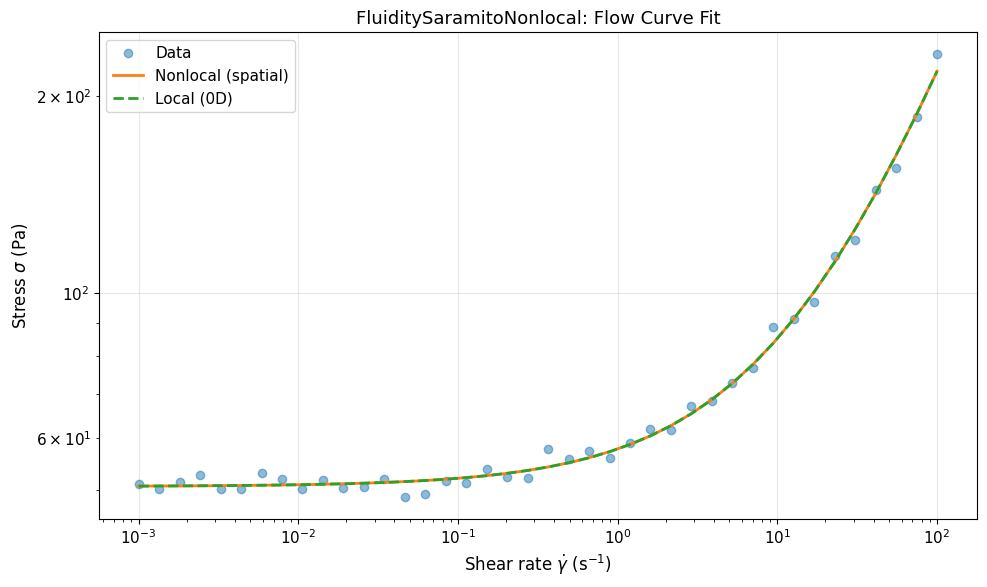

Results saved to: ../outputs/fluidity/saramito_nonlocal/flow_curve

Saved files:
  - nlsq_parameters.txt
  - bayesian_summary.txt
  - posterior.nc
  - flow_curve_comparison.png


In [13]:
# Create output directory
output_dir = Path('../outputs/fluidity/saramito_nonlocal/flow_curve')
output_dir.mkdir(parents=True, exist_ok=True)

# Collect fitted parameters
params_nlsq = {name: model_nonlocal.parameters.get_value(name) for name in model_nonlocal.parameters.keys()}

# Save fitted parameters (NLSQ)
params_file = output_dir / 'nlsq_parameters.txt'
with open(params_file, 'w') as f:
    f.write("FluiditySaramitoNonlocal - NLSQ Fitted Parameters\n")
    f.write("=" * 50 + "\n\n")
    f.write(f"R² = {r_squared:.6f}\n")
    f.write(f"RMSE = {rmse:.6f} Pa\n\n")
    for name, value in params_nlsq.items():
        f.write(f"{name} = {value:.6e}\n")

# Save Bayesian posterior summary
posterior_file = output_dir / 'bayesian_summary.txt'
with open(posterior_file, 'w') as f:
    f.write("FluiditySaramitoNonlocal - Bayesian Posterior Summary\n")
    f.write("=" * 50 + "\n\n")
    f.write(summary.to_string())

# Save ArviZ InferenceData
idata.to_netcdf(output_dir / 'posterior.nc')

# Save comparison plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.loglog(gamma_dot, stress, 'o', label='Data', alpha=0.5, markersize=6)
ax.loglog(gamma_dot, stress_fit_curve, '-', label='Nonlocal (spatial)', linewidth=2)
ax.loglog(gamma_dot, stress_local, '--', label='Local (0D)', linewidth=2)
ax.set_xlabel(r'Shear rate $\dot{\gamma}$ (s$^{-1}$)', fontsize=12)
ax.set_ylabel(r'Stress $\sigma$ (Pa)', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_title('FluiditySaramitoNonlocal: Flow Curve Fit', fontsize=13)
plt.tight_layout()
plt.savefig(output_dir / 'flow_curve_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close('all')

print(f"Results saved to: {output_dir}")
print("\nSaved files:")
print(f"  - {params_file.name}")
print(f"  - {posterior_file.name}")
print(f"  - posterior.nc")
print(f"  - flow_curve_comparison.png")

## Key Takeaways: When Do Spatial Effects Matter?

### Nonlocal vs Local Comparison

The **FluiditySaramitoNonlocal** model includes fluidity diffusion ($\xi^2 \partial^2 f/\partial y^2$), enabling:

1. **Shear Band Formation**
   - Spatial localization of flow (high γ̇) and jammed regions (low γ̇)
   - Critical when: $\xi / h > 0.1$ (diffusion length comparable to gap)

2. **Normal Stress Localization**
   - $N_1(y) = \tau_{xx}(y) - \tau_{yy}(y)$ varies across gap
   - Important for: edge fracture, wall slip detection

3. **Fluidity Gradients**
   - $\nabla f$ drives cooperative restructuring
   - Relevant when: aging time $t_a \sim \xi^2/D_f$ (diffusive timescale)

### When to Use Local vs Nonlocal

**Use Local (0D) Model** if:
- Flow curves are smooth (no sharp transitions)
- Gap width $h \gg \xi$ (typically $h > 1$ mm, $\xi \sim 10\text{-}100 \mu\text{m}$)
- No shear banding observed (e.g., via velocimetry)
- Computational speed is critical

**Use Nonlocal (1D) Model** if:
- Shear banding is suspected or observed
- Edge effects or wall slip are present
- Normal stress measurements show spatial variation
- Small gaps ($h < 500 \mu\text{m}$) or confined geometries

### Model Selection Criteria

| Indicator | Local | Nonlocal |
|-----------|-------|----------|
| Relative difference in fit | <5% | >10% |
| Gap/diffusion ratio $h/\xi$ | >10 | <10 |
| Flow homogeneity | Uniform | Banded |
| Computational cost | Low | Medium-High |

### Physical Interpretation

**Minimal coupling** ($\lambda = 1/f$ only):
- Captures thixotropic memory effects
- Suitable for weakly structured fluids

**Full coupling** ($\lambda + \tau_y(f)$):
- Includes aging-induced yield stress evolution
- Required for strongly structured systems (e.g., clays, gels)

The fluidity diffusion length $\xi$ controls the shear band width:
$$
\delta_{\text{band}} \sim \xi \sqrt{t_a \dot{\gamma}}
$$

Typical values: $\xi \sim 10\text{-}100 \mu\text{m}$, $\delta_{\text{band}} \sim 50\text{-}500 \mu\text{m}$ at $\dot{\gamma} \sim 1\text{-}10 \text{ s}^{-1}$.